`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

**Работу выполнил Кечин Дмитрий**


# Лабораторная работа №1: Оценка точности модели с непрерывной зависимой переменной

В практических примерах ниже показано:   

* как делить данные на выборки (обучающую и тестовую);  
* как считать MSE: среднеквадратическую ошибку модели;  
* как меняются MSE на тестовой и обучающей выборках с изменением гибкости (числа степеней свободы) модели.  

*Модели*: сглаживающие сплайны.   
*Данные*: сгенерированные.   

**Задача 1**. На данных своего варианта (см. второй столбец таблицы с вариантами) повторить расчёты и построить графики из первой лабораторной. Пояснить выбор наилучшего количества степеней свободы.

**Задача 2**. Повторить расчёты, меняя характеристики согласно своему варианту (см. последний столбец таблицы с вариантами). Проанализировать, как меняется MSE при изменении характеристик. 

Вариант 10:
* Задача 1: $f(X) = 6 + 3.5 \cdot \cos{\Big ( {x - 30 \over 12 } \Big )}$
* Задача 2: $n\_all = 150$, $n\_all = 100$, $n\_all = 50$ 


### Генерируем исходные данные

In [89]:
# загрузка пакетов
import numpy as np
import random
import matplotlib.pyplot as plt
from pandas import DataFrame
import rpy2.robjects as robjects

In [90]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10)

# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.85

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), replace = False)

# истинная функция взаимосвязи
def y_func (x) :
    return(6 + 3.5 * np.cos((x - 30) / 12))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)



### Строим графики   

Изобразим исходные данные на графике.   

In [91]:
# загрузка пакетов
import matplotlib.pyplot as plt

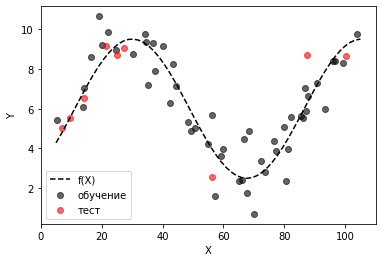

In [92]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

## Обучаем модели и оцениваем их точность

В качестве модели используем сплайны со степенями свободы от 2 (прямая) до 40 (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.    

In [93]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

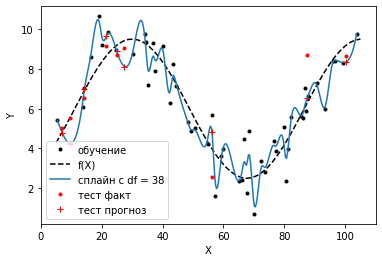

In [94]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
          sum((y_test - y_hat_test)**2) / len(y_test)]

Ошибки на обучающей и тестовой выборках составили соответственно:

In [95]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.27, 1.45])

In [96]:
#  Теперь строим модели с df от 2 до 40 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:  

In [97]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
24,0.651214,0.895104


Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели. 

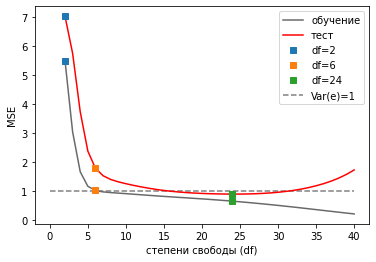

In [98]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([24, 24], [MSE_all_dfs.iloc[22]['MSE_train'], MSE_all_dfs.iloc[22]['MSE_test']],
         ls='', marker='s', label='df=24')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

# **Вывод к задаче 1:**
Наилучшее число степеней свободы для данной модели - 24, поскольку при нем достигается минимальная ошибка на тестовой выборке.

# **Задача 2:**
Кол-во наблюдений: *𝑛_𝑎𝑙𝑙=150*

# Генерируем новые данные:

In [99]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10)

# всего наблюдений, доля обучающей выборки
train_percent = 0.85
n_all = 150

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), replace = False)

# истинная функция взаимосвязи
def y_func (x) :
    return(6 + 3.5 * np.cos((x - 30) / 12))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

# **Строим графики**
Изобразим исходные данные на графике.

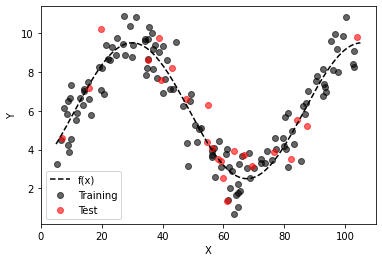

In [100]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color = 'black', label = 'Training', alpha = 0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color = 'red', label = 'Test', alpha = 0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color = 'black', linestyle = 'dashed', label = 'f(x)')

plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

# **Обучаем модели и оцениваем их точность**
В качестве модели используем сплайны со степенями свободы от 2 (прямая) до k (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.

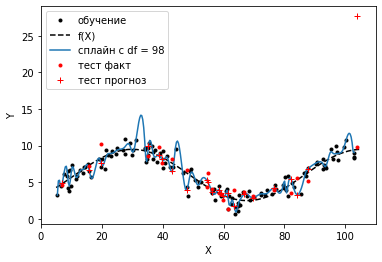

In [101]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = int(round((n_all * 2)/3)) - 2

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train), sum((y_test - y_hat_test)**2) / len(y_test)]

Ошибки на обучающей и тестовой выборках составили соответственно:

In [102]:

# выводим MSE с округлением
np.around(MSE_fit, 2)

array([ 0.34, 15.77])

In [103]:
#  Теперь строим модели с df от 2 до 100 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = my_df + 2
# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))


# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x = r_x, y = r_y, df = i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:


In [104]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
6,0.901754,0.908532


Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели.

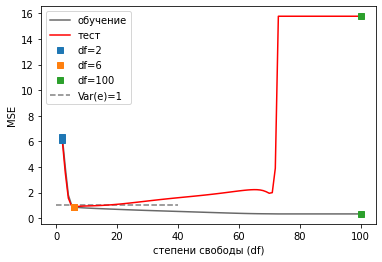

In [105]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([max_df, max_df], [MSE_all_dfs.iloc[my_df]['MSE_train'], MSE_all_dfs.iloc[my_df]['MSE_test']],
         ls='', marker='s', label='df=100')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

# **Вывод к задаче:**
Наилучшее число степеней свободы для данной модели - 6, поскольку при нем достигается минимальная ошибка на тестовой выборке.

Кол-во наблюдений: 𝑛_𝑎𝑙𝑙=100
# Генерируем новые данные

In [106]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10)

# всего наблюдений, доля обучающей выборки
train_percent = 0.85
n_all = 100

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), replace = False)

# истинная функция взаимосвязи
def y_func (x) :
    return(6 + 3.5 * np.cos((x - 30) / 12))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)


# **Строим графики**
Изобразим исходные данные на графике.

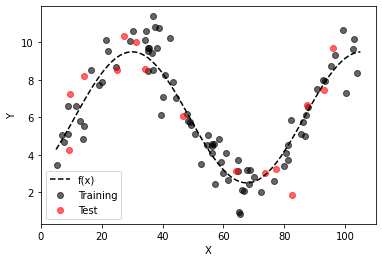

In [107]:
# график 2: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color = 'black', label = 'Training', alpha = 0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color = 'red', label = 'Test', alpha = 0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color = 'black', linestyle = 'dashed', label = 'f(x)')

plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

# **Обучаем модели и оцениваем их точность**
В качестве модели используем сплайны со степенями свободы от 2 (прямая) до k(количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.

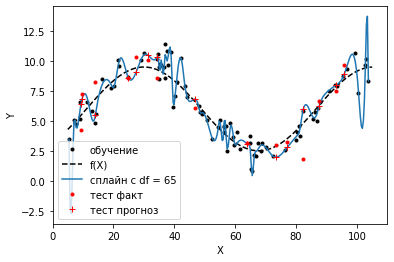

In [108]:

# модель натурального сплайна с заданным количеством узлов (df)
my_df = int(round(n_all * 2/3)) - 2

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train), sum((y_test - y_hat_test)**2) / len(y_test)]


Ошибки на обучающей и тестовой выборках составили соответственно:

In [109]:

# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.22, 2.47])

In [110]:
#  Теперь строим модели с df от 2 до my_df+ 2 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = my_df + 2

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x = r_x, y = r_y, df = i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:

In [111]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
6,0.938272,1.300582



Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели.

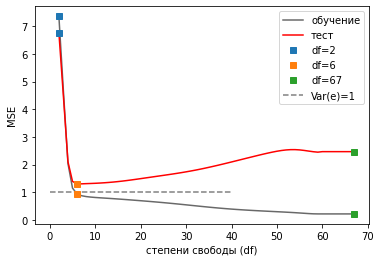

In [112]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([max_df, max_df], [MSE_all_dfs.iloc[my_df]['MSE_train'], MSE_all_dfs.iloc[my_df]['MSE_test']],
         ls='', marker='s', label='df=67')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

# **Вывод к задаче:**
Наилучшее число степеней свободы для данной модели - 6, поскольку при нем достигается минимальная ошибка на тестовой выборке.

# **Задача 2:**
Кол-во наблюдений: *𝑛_𝑎𝑙𝑙=50*

# Генерируем новые данные:

In [113]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10)

# всего наблюдений, доля обучающей выборки
train_percent = 0.85
n_all = 50

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 4
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), replace = False)

# истинная функция взаимосвязи
def y_func (x) :
    return(6 + 3.5 * np.cos((x - 30) / 12))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

# **Строим графики**
Изобразим исходные данные на графике.

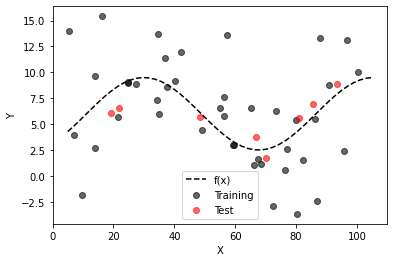

In [114]:

# график 3: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color = 'black', label = 'Training', alpha = 0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color = 'red', label = 'Test', alpha = 0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color = 'black', linestyle = 'dashed', label = 'f(x)')

plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

Обучаем модели и оцениваем их точность
В качестве модели используем сплайны со степенями свободы от 2 (прямая) до k (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.

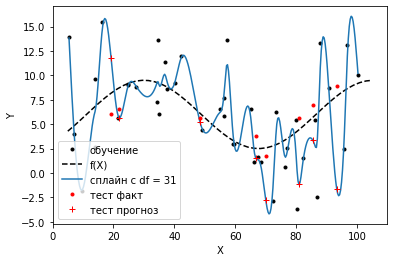

In [115]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 31

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train), sum((y_test - y_hat_test)**2) / len(y_test)]

Ошибки на обучающей и тестовой выборках составили соответственно:

In [116]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([ 3.7 , 28.74])

In [117]:

#  Теперь строим модели с df от 2 до my_df + 2 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 33

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df + 1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns = ['MSE_train', 'MSE_test'], index = list(range(2, max_df + 1)))


# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x = r_x, y = r_y, df = i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)


Минимум MSE на тестовой выборке достигается при числе степеней свободы:

In [118]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
4,17.148354,3.908151



Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели.

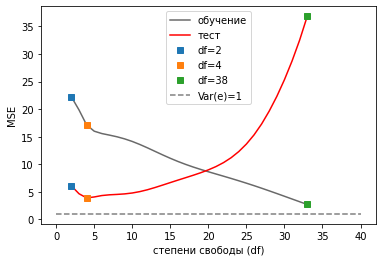

In [119]:

# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([4, 4], [MSE_all_dfs.iloc[2]['MSE_train'], MSE_all_dfs.iloc[2]['MSE_test']],
         ls='', marker='s', label='df=4')
plt.plot([max_df, max_df], [MSE_all_dfs.iloc[my_df]['MSE_train'], MSE_all_dfs.iloc[my_df]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

# **Вывод к задаче:**
Наилучшее число степеней свободы для данной модели - 4, поскольку при нем достигается минимальная ошибка на тестовой выборке.

# **Результаты MSE на train и test:**


*   60 - 0.651214	0.895104
*   150 - 0.901754	0.908532
*   100 - 0.938272	1.300582
*   50 - 17.148354	3.90815
